# <center> Deep RNNs <center>

## Main

It is quite common to stack multiple layers of cells, to implement a deep RNN in TensorFlow, you can create several cells and stack them into a MultiRNNCell. In the following code we stack three identical cells (but you could very well use various kinds of cells with a different number of neurons):

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [3]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [4]:
init = tf.global_variables_initializer()

In [5]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [6]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

The states variable is a tuple containing one tensor per layer, each representing the final state of that layer’s cell (with shape [batch_size, n_neurons]). If you set state_is_tuple=False when creating the MultiRNNCell, then states becomes a single tensor containing the states from every layer, concatenated along the column axis.

In [7]:
outputs_val.shape

(2, 5, 100)

In [8]:
# Applying to mnist data
n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
tf.reset_default_graph()

In [11]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94 Test accuracy: 0.9455
1 Train accuracy: 0.966667 Test accuracy: 0.9638
2 Train accuracy: 0.973333 Test accuracy: 0.971
3 Train accuracy: 0.993333 Test accuracy: 0.9721
4 Train accuracy: 0.986667 Test accuracy: 0.9703
5 Train accuracy: 0.986667 Test accuracy: 0.9786
6 Train accuracy: 0.986667 Test accuracy: 0.9812
7 Train accuracy: 0.986667 Test accuracy: 0.9773
8 Train accuracy: 0.986667 Test accuracy: 0.9786
9 Train accuracy: 0.98 Test accuracy: 0.982


## Applying Dropout

If you build a very deep RNN, it may end up overfitting the training set. To prevent that, a common technique is to apply dropout. The input_keep_prob parameter can be a placeholder, making it possible to set it to any value you want during training, and to 1.0 during testing (effectively turning dropout off).

In [20]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)


In [23]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

In [12]:
tf.reset_default_graph()

In [13]:
n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [14]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [15]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [16]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 19.0388
100 Training MSE: 4.83606
200 Training MSE: 4.37401
300 Training MSE: 3.31858
400 Training MSE: 3.45498
500 Training MSE: 3.37889
600 Training MSE: 3.2635
700 Training MSE: 3.70782
800 Training MSE: 2.94966
900 Training MSE: 3.25598
1000 Training MSE: 3.28181
1100 Training MSE: 3.49934
1200 Training MSE: 4.00699
1300 Training MSE: 3.9992
1400 Training MSE: 4.26171


In [24]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


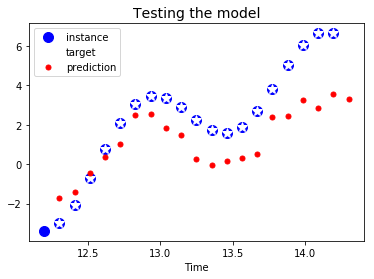

In [27]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## The Difficulty of Training over Many Time Steps

To train an RNN on long sequences, you will need to run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the vanishing/exploding gradients problem and take forever to train. Many of the tricks we discussed to alleviate this problem can be used for deep unrolled RNNs as well: good parameter initialization,
nonsaturating activation functions (e.g., ReLU), Batch Normalization, Gradient Clipping, and faster optimizers. 

However, if the RNN needs to handle even moderately long sequences (e.g., 100 inputs), then training will still be very slow.
The simplest and most common solution to this problem is to unroll the RNN only over a limited number of time steps during training. This is called truncated backpropagation through time. In TensorFlow you can implement it simply by truncating the
input sequences. For example, in the time series prediction problem, you would simply reduce n_steps during training. The problem, of course, is that the model will not be able to learn long-term patterns. One workaround could be to make sure that
these shortened sequences contain both old and recent data, so that the model can learn to use both (e.g., the sequence could contain monthly data for the last five months, then weekly data for the last five weeks, then daily data over the last five
days). But this workaround has its limits: what if fine-grained data from last year is actually useful? What if there was a brief but significant event that absolutely must be taken into account, even years later (e.g., the result of an election)?

Besides the long training time, a second problem faced by long-running RNNs is the fact that the memory of the first inputs gradually fades away. Indeed, due to the transformations that the data goes through when traversing an RNN, some information is
lost after each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. For example, say you want to perform sentiment analysis on a long review that starts with the four words “I loved this movie,” but the rest of the review lists the many things that could have made the movie even better. If the RNN gradually forgets the first four words, it will completely misinterpret the review. To solve this problem, various types of cells with long-term memory have been introduced. They have proved so successful that the basic cells are not much used anymore. Let’s first look at the most popular of these long memory cells: the LSTM cell.

## LSTM Cell

The Long Short-Term Memory (LSTM) cell was proposed in 19973 by Sepp Hochreiter and Jürgen Schmidhuber, and it was gradually improved over the years by several researchers, such as Alex Graves, Haşim Sak,4 Wojciech Zaremba,5 and many more. If
you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster and it will detect long-term dependencies in the data.

In [1]:
from IPython.display import Image

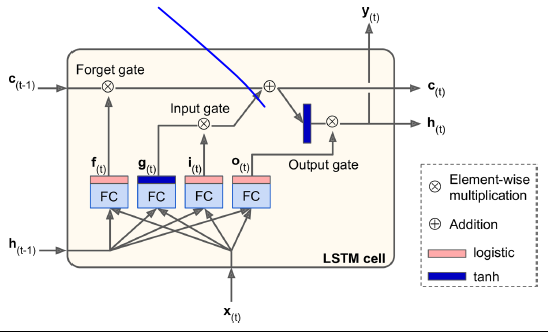

In [2]:
Image("./LSTM.PNG")

If you don’t look at what’s inside the box, the LSTM cell looks exactly like a regular cell, except that its state is split in two vectors: h(t) and c(t) (“c” stands for “cell”). 

You can think of h(t) as the short-term state and c(t) as the long-term state. Now let’s open the box! The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it. As the long-term state
c(t–1) traverses the network from left to right, you can see that it first goes through a forget gate, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an input gate).
The result c(t) is sent straight out, without any further transformation. So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the output gate. 

This produces the short-term state h(t) (which is equal to the cell’s output for this time step y(t)). Now let’s look at
where new memories come from and how the gates work. First, the current input vector x(t) and the previous short-term state h(t–1) are fed to four different fully connected layers. They all serve a different purpose:
- The main layer is the one that outputs g(t). It has the usual role of analyzing the current inputs x(t) and the previous (short-term) state h(t–1). In a basic cell, there is nothing else than this layer, and its output goes straight out to y(t) and h(t). In contrast, in an LSTM cell this layer’s output does not go straight out, but instead it is partially stored in the long-term state.

- The three other layers are gate controllers. Since they use the logistic activation function, their outputs range from 0 to 1. As you can see, their outputs are fed to element-wise multiplication operations, so if they output 0s, they close the gate, and if they output 1s, they open it. Specifically:
    - The forget gate (controlled by f(t)) controls which parts of the long-term state should be erased.
    - The input gate (controlled by i(t)) controls which parts of g(t) should be added to the long-term state (this is why we said it was only “partially stored”).
    - Finally, the output gate (controlled by o(t)) controls which parts of the longterm state should be read and output at this time step (both to h(t)) and y(t).


In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, learn to preserve it for as long as it is needed (that’s the role of the forget gate), and learn to extract it whenever it is needed. This explains why they have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

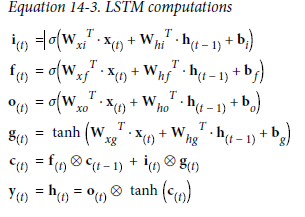

In [3]:
Image("./LSTM_Equ.PNG")

In [5]:
tf.reset_default_graph()

In [6]:

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [7]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [18]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [21]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.926667 Test accuracy = 0.956
Epoch 1 Train accuracy = 0.986667 Test accuracy = 0.9751
Epoch 2 Train accuracy = 1.0 Test accuracy = 0.9729
Epoch 3 Train accuracy = 1.0 Test accuracy = 0.9826
Epoch 4 Train accuracy = 1.0 Test accuracy = 0.983
Epoch 5 Train accuracy = 0.986667 Test accuracy = 0.9833
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9862
Epoch 7 Train accuracy = 0.993333 Test accuracy = 0.9842
Epoch 8 Train accuracy = 0.993333 Test accuracy = 0.9849
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9875


### Peephole Connections

In a basic LSTM cell, the gate controllers can look only at the input x(t) and the previous short-term state h(t–1). It may be a good idea to give them a bit more context by letting them peek at the long-term state as well. This idea was proposed by Felix Gers and Jürgen Schmidhuber. They proposed an LSTM variant with extra connections called peephole connections: the previous long-term state c(t–1) is added as an input to the controllers of the forget gate and the input gate, and the current longterm state c(t) is added as input to the controller of the output gate.

To implement peephole connections in TensorFlow, you must use the LSTMCell instead of the BasicLSTMCell and set use_peepholes=True:

In [22]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

## GRU Cell

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well (which explains its growing popularity). The main simplifications are:
- Both state vectors are merged into a single vector h(t).
- A single gate controller controls both the forget gate and the input gate. If the gate controller outputs a 1, the forget gate is open and the input gate is closed. If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a frequent variant to the LSTM cell in and of itself.
- There is no output gate; the full state vector is output at every time step. However, there is a new gate controller that controls which part of the previous state will be shown to the main layer.

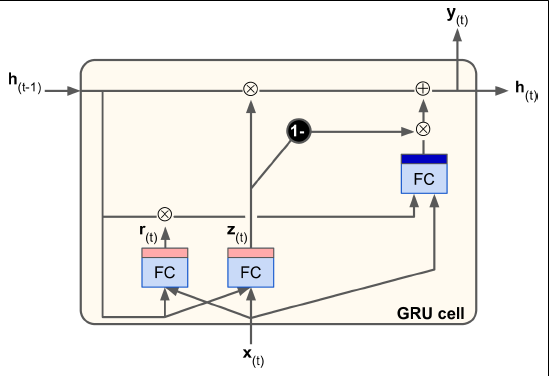

In [23]:
Image("./GNU.PNG")

Creating a GRU cell in TensorFlow is trivial:

In [24]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)